# Load dataset

In [ ]:
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

# Cargar el conjunto de datos MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# Pre processing

In [ ]:
from tensorflow.keras.utils import to_categorical

# Preprocesar los datos
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)

# Convertir los valores de los píxeles a float32
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Normalizar los valores de los píxeles entre 0 y 1
x_train /= 255
x_test /= 255

# Convertir las etiquetas a formato one-hot
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

x_train.shape, y_train.shape

((60000, 28, 28, 1), (60000, 10))

# Train

## DNN

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.metrics import Precision, Recall, F1Score, CategoricalAccuracy

# ------------------ Regularización de la Arquitectura del Modelo ------------------
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout
from tensorflow.keras.layers import Dropout, BatchNormalization


# Crear el modelo de red neuronal profunda
def build_model(optimazer, regularizer=None, dropout_layer=False, batch_normalization_layer=False):
  if optimazer is None:
    optimazer = Adam(learning_rate=0.01)

  model_dnn = Sequential()
  # Capa entrada
  model_dnn.add(Flatten(input_shape=(28, 28, 1)))

  # Capa oculta 1
  model_dnn.add(Dense(128, activation='relu', kernel_regularizer=regularizer))

  if batch_normalization_layer is True:
    model_dnn.add(BatchNormalization(center=True, scale=True))

  # Capa oculta 2
  model_dnn.add(Dense(128, activation='relu', kernel_regularizer=regularizer))

  if dropout_layer is True:
    model_dnn.add(Dropout(0.2))


  # Capa salida
  model_dnn.add(Dense(10, activation='softmax'))

  # Compilar el modelo
  model_dnn.compile(
      loss='categorical_crossentropy',
      optimizer=optimazer,
      metrics=[
          CategoricalAccuracy(),
          Precision(),
          Recall(),
          F1Score()
      ]
  )
  return model_dnn

## Regularizadores

In [ ]:
# https://www.tensorflow.org/api_docs/python/tf/keras/regularizers
from tensorflow.keras.regularizers import L1, L2, L1L2

l1 = L1(l1=0.001)
l2 = L2(l2=0.001)
l1_l2 = L1L2(l1=0.001, l2=0.001)

regularizer = l1_l2

## Métodos de Optimización

In [ ]:
# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
from tensorflow.keras.optimizers import SGD, Adagrad, Adadelta,  RMSprop, Adam

sdg = SGD(learning_rate=0.01)
momentum = SGD(learning_rate=0.01, momentum=0.2)
adagrad = Adagrad(learning_rate=0.01)
adadelta = Adadelta(learning_rate=0.01)
rsm_prop = RMSprop(learning_rate=0.01)
adam = Adam(learning_rate=0.01)

optimazer = adam

In [ ]:
model_dnn = build_model(optimazer=optimazer, regularizer=regularizer, dropout_layer=True, batch_normalization_layer=True)
model_dnn.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 118,794 (464.04 KB)

 Trainable params: 118,538 (463.04 KB)

 Non-trainable params: 256 (1.00 KB)

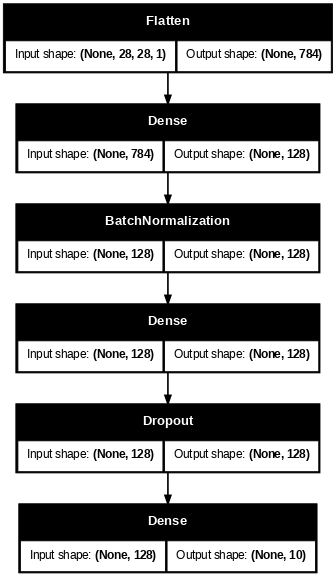

In [ ]:
# Show diagram
tf.keras.utils.plot_model(model_dnn, show_shapes=True, dpi=60)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# ------------------ Mejoras en el Proceso de Entrenamiento ------------------
model_dnn_file = 'model_dnn.keras'
checkpoint = ModelCheckpoint(model_dnn_file, monitor="val_categorical_accuracy", mode="max", save_best_only=True)
early_stopping = EarlyStopping(monitor="val_categorical_accuracy", mode="max", patience=100, verbose=1)

# Entrenar el modelo
dnn_train_history = model_dnn.fit(
    x_train,
    y_train,
    epochs=20000, # Iteraciones
    batch_size=1000, # Batch: Cada que tantos registros aplica
    verbose=1,
    validation_split=0.2,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/20000
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - categorical_accuracy: 0.7985 - f1_score: 0.7961 - loss: 3.8612 - precision_1: 0.9005 - recall_1: 0.7392 - val_categorical_accuracy: 0.8059 - val_f1_score: 0.8059 - val_loss: 1.9257 - val_precision_1: 0.9970 - val_recall_1: 0.1673
Epoch 2/20000
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - categorical_accuracy: 0.9329 - f1_score: 0.9324 - loss: 0.9719 - precision_1: 0.9532 - recall_1: 0.9129 - val_categorical_accuracy: 0.8813 - val_f1_score: 0.8853 - val_loss: 1.3177 - val_precision_1: 0.9823 - val_recall_1: 0.6297
Epoch 3/20000
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - categorical_accuracy: 0.9399 - f1_score: 0.9393 - loss: 0.8539 - precision_1: 0.9551 - recall_1: 0.9265 - val_categorical_accuracy: 0.8975 - val_f1_score: 0.8952 - val_loss: 1.0395 - val_precision_1: 0.9482 - val_recall_1: 0.8163
Epoch 4/20000
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - categorical_accuracy: 0.9437 - f1_score: 0.9431 - loss: 0.7860 - precision_1: 0.9557 - re

In [ ]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-mkeb5nm5
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-mkeb5nm5
  Resolved https://github.com/tensorflow/docs to commit 15e96c3ee154d7c10ec9bb807ef44b4e6f08e65b
  Preparing metadata (setup.py) ... done


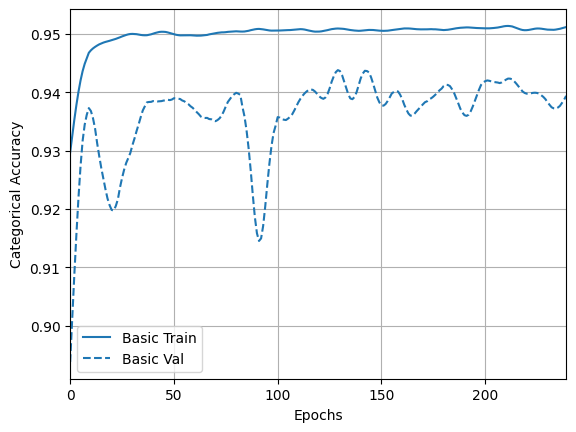

In [ ]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

plotter.plot({'Basic': dnn_train_history}, metric="categorical_accuracy")

In [ ]:
# Get best model
model_dnn.load_weights(model_dnn_file)

# Evaluar el modelo: Error de Generalización
score_dnn = model_dnn.evaluate(x_test, y_test, verbose=0)
print('Precisión del modelo DNN:', score_dnn[1])

Precisión del modelo DNN: 0.9552000164985657
